Module Code: ST1504 DELE

Name: Yadanar Aung

Admin No.: 2214621

Class: DAAA/FT/2B/07

CA1: Part B Recurrent Neural Network

<hr>
<h3>Importing Libraries</h3>

In [12]:
import tensorflow as tf

# Check GPU is available
gpus = tf.config.experimental.list_physical_devices('GPU')

# Memory control: Prevent tensorflow from allocating totality of GPU memory
for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
# pip install nltk
# pip install keras-nlp

In [13]:
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import nltk

# Preprocessing Data
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import utils

# Building CNN Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, SimpleRNN, Dense, Dropout, Bidirectional, SpatialDropout1D

# Evaluation
from nltk.translate.bleu_score import sentence_bleu
from nltk.tokenize import word_tokenize

In [14]:
# Fix random seed for reproducibility
seed = 42
np.random.seed(seed)

<hr>
<h3><mark>Define Task</mark></h3>
<p> ↳ Build a <u>next -word predictor</u> given a sequence of words.</p>

- <u>Input</u>: Sequence of words of any length (e.g. one words, five words, etc.).
- <u>Output</u>: Word that follows that sequence of words.

<br>
↳ Additional Information:

- In principle, given an input to model, can ask model to predict next ten words, by <u><b>asking model to predict next word ten times</b></u>.

- Model should be capable of <u><b>producing different sequences of outputs texts</b></u>, given same input.

- Devise ways to <b><u>evaluate generated sequence of words</u></b>, how meaningful they are, or how creative they are, using the given seed_texts as a benchmark.

Test model by applying the following ten example sequences of words as inputs:

In [15]:
seed_texts = ['embrace each day',
'radiate some',
'believe that',
"life's actual purpose is",
'dance through each and every',
'let your time and energy',
'every person is',
'our country Singapore is',
'planet earth is',
'morning and evening would make it']

As we can see, the test cases are in lower case.

<hr>
<h2><mark>1. Background Research</mark></h2>


Predicting the next word, in other words is called text generation.

What is Text Generation:
- Text Generation is the task of producing new text. It is the process where an AI system produces written content, <u>imitating human language patterns and styles</u>.
- The process involves generating coherent and meaningful text that resembles natural human communication.

How it works:
- It utilizes algorithms and language models to process input data and generate output text. 
- It involves training AI models on large datasets of text to <u>learn patterns, grammar, and contextual information</u>. These models then use this learned knowledge to generate new text based on given prompts or conditions.

Well-Known Language Models:
- GTP (Generative Pre-trained Transformer)
- Google's PaLM

Uses:
- Chatbots
- Language Translation
- Summarization

Source: https://www.datacamp.com/blog/what-is-text-generation

<hr>
<h2><mark>2. Data Understanding</mark></h2>

- Import Dataset
- Exploratory Data Analysis

<h3><b>Import Dataset: train.csv</b></h3>

Total of 1000 quotes.

In [22]:
# Read data
train_csv = pd.read_csv('Data/train.csv')
train_csv

,Quotes
0,Embrace the beauty of every sunrise; it's a fr...
1,Embrace challenges; they are the stepping ston...
2,Embrace the rhythm of life and let it dance th...
3,"Embrace kindness, for it has the power to chan..."
4,"Embrace the journey, for it leads to the desti..."
...,...
995,"With an open heart, welcome the opportunities ..."
996,"This morning, let your laughter be the music t..."
997,"In the serenity of this morning, find the powe..."
998,"This morning, let your actions be a testament ..."


<hr>
<h3><mark><b>Exploratory Data Analysis</b></mark></h3>

<h4><b>Information of the Dataset</b></h4>

In [23]:
train_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Quotes  1000 non-null   object
dtypes: object(1)
memory usage: 7.9+ KB


There are no missing quotes in the dataset.

<hr>
<h4><b>Statistical Description of the Dataset</b></h4>

In [24]:
train_csv.describe()

,Quotes
count,1000
unique,890
top,"Radiate acceptance, and find peace in embracin..."
freq,5


There are a total of 1000 quotes in the dataset.

There are <u>110 repeated quotes</u> in the dataset, as there are only 890 unqiue quotes. 

For instance, the quote "Radiate acceptance, and find peace in embracing what is." is repeated five times in the dataset.

<h5><b>Handle Reapted Quotes in Dataset</b></h5>

I will be dropping the duplicates, if not they would influence the model during training by introducing biasness.

In [25]:
train_csv_noDups = train_csv.drop_duplicates().reset_index(drop=True)
train_csv_noDups

,Quotes
0,Embrace the beauty of every sunrise; it's a fr...
1,Embrace challenges; they are the stepping ston...
2,Embrace the rhythm of life and let it dance th...
3,"Embrace kindness, for it has the power to chan..."
4,"Embrace the journey, for it leads to the desti..."
...,...
885,"With an open heart, welcome the opportunities ..."
886,"This morning, let your laughter be the music t..."
887,"In the serenity of this morning, find the powe..."
888,"This morning, let your actions be a testament ..."


<hr>
<h4><b>Word Length of Quotes in Dataset</b></h4>

Total Unique Words across all quotes: 1592
Mean Number of Words in a quote: 11.910112359550562
Mean Number of Words in a quote: 11.0


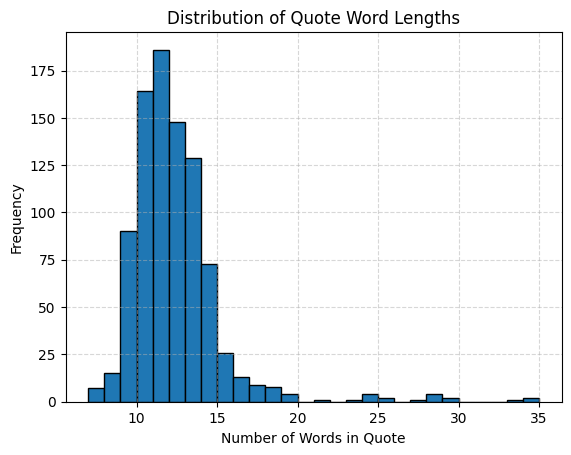

In [26]:
# Store all words from all quotes in a list
wordBank = []
for quote in train_csv_noDups['Quotes']:
    for word in quote.split(): # Split sentence into words
        wordBank.append(word)

# Store all quotes' lengths in a list
lengthBank = []
for quote in train_csv_noDups['Quotes']:
    lengthBank.append(len(quote.split()))
    
print("Total Unique Words across all quotes:", len(set(wordBank)))
print("Mean Number of Words in a quote:", np.mean(lengthBank))
print("Mean Number of Words in a quote:", np.median(lengthBank))

# Historgram of Quote Word Lengths
plt.hist(lengthBank, bins = range(min(lengthBank), max(lengthBank) + 1), edgecolor = 'black')
plt.title('Distribution of Quote Word Lengths')
plt.xlabel('Number of Words in Quote')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Insights:

- The most common quote lengths are 11 to 13 words.

<h4><b>Count of Word Occurrence in Quotes</b></h4>

Unqiue Words: 1592
{'the': 867, 'of': 663, 'your': 350, 'and': 322, 'a': 307, 'is': 252, 'for': 201, 'to': 180, 'it': 176, 'in': 170, 'be': 170, 'that': 123, 'you': 121, 'Every': 120, 'let': 117, 'Embrace': 99, 'are': 96, "Life's": 95, 'Radiate': 92, 'our': 91, 'Believe': 83, 'yourself,': 83, 'In': 79, 'morning,': 76, 'through': 75, 'with': 71, 'Let': 70, 'Dance': 63, "planet's": 63, 'will': 62, 'this': 61, 'they': 50, "Singapore's": 50, 'Our': 49, 'This': 49, 'power': 46, 'heart': 44, 'we': 43, 'every': 39, 'act': 38, 'symphony': 37, 'find': 37, 'love': 34, 'Singapore,': 33, 'From': 33, 'kindness': 32, 'life.': 31, 'soul.': 29, 'light': 29, 'heart.': 27, 'beauty': 26, 'colors': 25, 'where': 25, 'planet.': 25, 'whispers': 24, 'dreams': 24, 'With': 24, 'canvas': 23, 'dance': 22, 'towards': 22, 'testament': 22, 'true': 21, 'new': 20, 'beacon': 20, "life's": 19, 'way.': 19, 'gratitude': 19, 'promise': 18, 'step': 18, 'nature': 18, 'morning': 18, 'hold': 17, 'an': 17, 'actions': 17, 'world

C:\Users\Admin\AppData\Local\Temp\ipykernel_45292\1283604917.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=counts, y=top_words, palette="viridis")


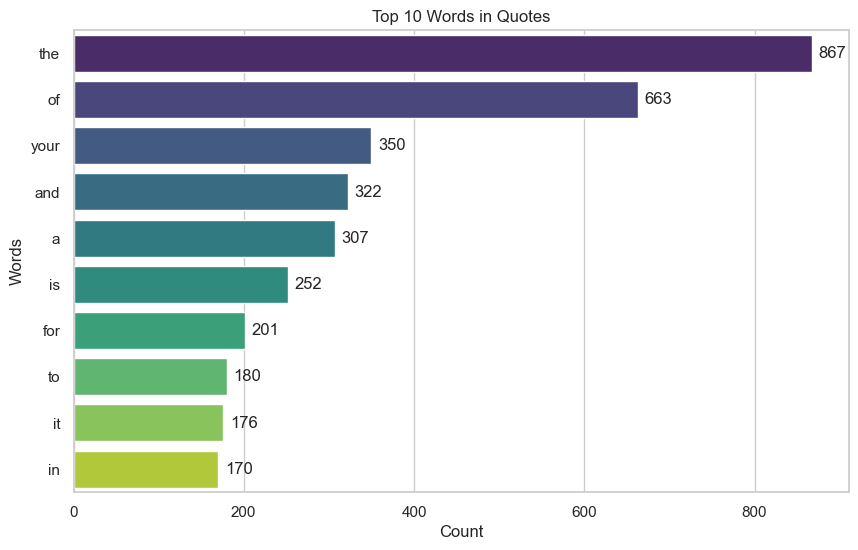

In [27]:
wordCounts = {}
for word in wordBank:
    if word in wordCounts:
        wordCounts[word] += 1
    else:
        wordCounts[word] = 1
        
# Sort by count in descending order
wordCounts = dict(sorted(wordCounts.items(), key=lambda x: x[1], reverse=True))
print('Unqiue Words:', len(wordCounts))
print(wordCounts)

# Get the top 10 words and their counts
top_words = list(wordCounts.keys())[:10]
counts = [wordCounts[word] for word in top_words]

# Horizontal Bar Graph
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=counts, y=top_words, palette="viridis")

# Add values next to the bars
for p, count in zip(ax.patches, counts):
    ax.annotate(str(count), (p.get_x() + p.get_width(), p.get_y() + p.get_height() / 2),
                ha='left', va='center', xytext=(5, 0), textcoords='offset points')

plt.xlabel('Count')
plt.ylabel('Words')
plt.title('Top 10 Words in Quotes')
plt.show()

The top five common words are 'the', 'of', 'your', 'and' & 'a'. These words are common as they are a type of determiner and they would go before a noun.

<hr>
<h4><b>Language Check the Quotes</b></h4>

To check if the quotes were grammerly correct, free of spelling mistakes and made sense, I used the <u>language-tool-python package</u> and also avaliable langauge checker websites such as <u>QuillBot</u> to check the grammer of the original 1000 quotes in the train_csv.

I had ran it using the public LanguageTool remote server. It took a couple of hours to run it as it was sending queries to the public server.

Hence, I only have the excel sheet containing the errors identified by the language_tool_python.

Source: <br>
https://pypi.org/project/language-tool-python/<Br>
https://quillbot.com/grammar-check<br>

In [80]:
import language_tool_python
# built-in class for querying LanguageTool's public servers
tool = language_tool_python.LanguageToolPublicAPI('en-US') # use the public API

In [84]:
language_errors = pd.read_csv('Data/error_quote_df.csv')
language_errors_list = language_errors['Quotes'].tolist()
language_errors

,Quotes
0,"From Sentosa's beaches to Chinatown's alleys, ..."
1,"The Merlion stands tall, a symbol of Singapore..."
2,From Merlion Park to Bukit Timah Nature Reserv...
3,"From Sentosa's shores to Pulau Ubin's trails, ..."
4,From Chinatown's lanterns to Kampong Glam's co...
5,From Pulau Tekong's quiet to the Southern Isla...
6,From Jurong Bird Park's colors to Night Safari...
7,From East Coast Park's breezes to Pulau Semaka...
8,From Peranakan houses to colonial architecture...
9,From Changi Airport's efficiency to Singapore ...


Let's take a look at the errors encountered.

In [85]:
for quote in language_errors_list:
    grammar_errors_output = tool.check(quote)
    print(grammar_errors_output)
    # Print the quote
    print(f"Quote: {quote}")
    print()

[Match({'ruleId': 'MORFOLOGIK_RULE_EN_US', 'message': 'Possible spelling mistake found.', 'replacements': ['Santos', 'Senora', 'CentOS', 'Mentos', 'Santosh', 'Ventose', 'Ventôse', 'Bentos', 'Pentosan', 'Señora'], 'offsetInContext': 5, 'context': "From Sentosa's beaches to Chinatown's alleys, Singap...", 'offset': 5, 'errorLength': 7, 'category': 'TYPOS', 'ruleIssueType': 'misspelling', 'sentence': "From Sentosa's beaches to Chinatown's alleys, Singapore's charm is boundless."})]
Quote: From Sentosa's beaches to Chinatown's alleys, Singapore's charm is boundless.

[Match({'ruleId': 'MORFOLOGIK_RULE_EN_US', 'message': 'Possible spelling mistake found.', 'replacements': ['Merlin', 'Merlon'], 'offsetInContext': 4, 'context': "The Merlion stands tall, a symbol of Singapore's st...", 'offset': 4, 'errorLength': 7, 'category': 'TYPOS', 'ruleIssueType': 'misspelling', 'sentence': "The Merlion stands tall, a symbol of Singapore's strength and grace."})]
Quote: The Merlion stands tall, a symbol 

If we observe, the errors were trigged due to the words not being in English. As we seen across the qutoes with triggered language errors, they contained malay Singaporean words such as Merlion and Sentosa.

Despite these errors, I will not be making any language changes as I would like to fit these words & patterns into the model during training.

<hr>
<h2><mark>3. Data Pre-processing</mark></h2>

<h3><b>Tokenization</b></h3>

To split sentences into smaller units of words to be easily asssigned meaning.

To <u>convert text to integers</u> by buiding a map for words to indexes.

In [28]:
# Convert data to a list in order to use Tokenzier Object
train_list = list(train_csv_noDups.Quotes.values)
print(f'There are {len(train_csv_noDups)} quotes in this dataset.')

# Print first five quotes in list
print("\nFirst five quotes in list:") 
for i in range(5):
    print(train_list[i])

There are 890 quotes in this dataset.

First five quotes in list:
Embrace the beauty of every sunrise; it's a fresh chance to paint your world with joy.
Embrace challenges; they are the stepping stones to your greatest victories.
Embrace the rhythm of life and let it dance through your soul.
Embrace kindness, for it has the power to change the world one heart at a time.
Embrace the journey, for it leads to the destination of your dreams.


<h4><b>Convert text to integers</b></h4>
Most frequent word has a smaller index.

Starts from 1, as 0 is reserved for padding so that all inputs would have the same length despite having different lengths.

In [29]:
# Instantiate a Tokenizer object
tokenizer = Tokenizer()

# Fit Tokenizer on dataset
# This will map words in dataset to integers
tokenizer.fit_on_texts(train_list) 
# Note that index starts with 1, not 0.
print(tokenizer.word_index)

# Because index 0 is reserved for padding
total_words = len(tokenizer.word_index) + 1 
print('\nTotal words across all quotes (Vocab Size):', total_words)

{'the': 1, 'of': 2, 'your': 3, 'and': 4, 'a': 5, 'is': 6, 'in': 7, 'for': 8, 'let': 9, 'to': 10, 'it': 11, 'be': 12, 'every': 13, 'our': 14, 'you': 15, 'that': 16, 'embrace': 17, "life's": 18, 'this': 19, 'are': 20, 'morning': 21, 'with': 22, 'radiate': 23, 'dance': 24, 'heart': 25, 'believe': 26, 'yourself': 27, 'through': 28, "planet's": 29, 'will': 30, 'life': 31, 'love': 32, 'they': 33, "singapore's": 34, 'kindness': 35, 'power': 36, 'from': 37, 'dreams': 38, 'we': 39, 'soul': 40, 'symphony': 41, 'act': 42, 'find': 43, 'gratitude': 44, 'singapore': 45, 'world': 46, 'strength': 47, 'light': 48, 'beauty': 49, 'journey': 50, 'nature': 51, 'joy': 52, 'planet': 53, 'canvas': 54, 'colors': 55, 'way': 56, 'whispers': 57, 'where': 58, 'potential': 59, 'hope': 60, 'testament': 61, 'resilience': 62, 'towards': 63, 'true': 64, 'new': 65, 'compassion': 66, 'beacon': 67, 'actions': 68, 'future': 69, 'spirit': 70, 'step': 71, 'change': 72, 'wisdom': 73, 'moments': 74, 'promise': 75, 'garden': 76

The total words is different from the total unique words eariler on which was 1592. 

This is because the Tokenizer removed all the punctuation and accounted the same for words with different casing.

<hr>
<h3><b>Build Input Sequence Data:</b> Use map to convert sentences to sequence of integers</h3>

Under Tokenizer object, we can <u>convert texts to sequences of integers</u>.

In [30]:
# Converts each of the 899 quotes from texts to integers
input_sequence = []

for datapoint in train_list:
    token_list = tokenizer.texts_to_sequences([datapoint])[0] # this extra [0] is because the output is a list of list                                
    input_sequence.append(token_list)

print(f'Total number of quotes: {len(input_sequence)}')
print('\nFirst five quotes:')
input_sequence[:5]

Total number of quotes: 890

First five quotes:


[[17, 1, 49, 2, 13, 77, 372, 5, 163, 486, 10, 101, 3, 46, 22, 52],
 [17, 148, 33, 20, 1, 373, 487, 10, 3, 374, 687],
 [17, 1, 119, 2, 31, 4, 9, 11, 24, 28, 3, 40],
 [17, 35, 8, 11, 149, 1, 36, 10, 72, 1, 46, 375, 25, 488, 5, 299],
 [17, 1, 50, 8, 11, 247, 10, 1, 688, 2, 3, 38]]

<hr>
<h3><b>Generate Input-Output Pairs</b></h3>

This helps to train the model to predict the next word using n words. This helps to generate more training dataset.

The input is every one word and the corresponding output is the following word.

In [31]:
# Function to generate input output pairs
# Chop up sentences into n words to predict next word
def generate_input_output_pairs(input_sequence, n):
    input_output_pair = []
    for datapoint in input_sequence:
        for i in range(len(datapoint) - n + 1): # - n + 1 to ensure that pairs dont'go beyond the length of the datapoint
            input_output_pair.append(datapoint[i:i + n])
    return input_output_pair

In [32]:
# List of 2 words
input_output_pair2 = generate_input_output_pairs(input_sequence, 2) # predict next word using 2 words
# List of 3 words
input_output_pair3 = generate_input_output_pairs(input_sequence, 3) # predict next word using 2 words
# List of 4 words
input_output_pair4 = generate_input_output_pairs(input_sequence, 4) # predict next word using 2 words
# List of 5 words
input_output_pair5 = generate_input_output_pairs(input_sequence, 5) # predict next word using 2 words

print('First 2 Original quotes:')
print(input_sequence[0:2])

print('\nTotal number of input-ouput pairs (two words):', len(input_output_pair2))
print('Each quote chopped into phrases of two words:')
print(input_output_pair2[:20])

print('\nTotal number of input-ouput pairs (three words):', len(input_output_pair3))
print('Each quote chopped into phrases of three words:')
print(input_output_pair3[:20])

print('\nTotal number of input-ouput pairs (four words):', len(input_output_pair4))
print('Each quote chopped into phrases of four words:')
print(input_output_pair4[:20])

print('\nTotal number of input-ouput pairs (five words):', len(input_output_pair5))
print('Each quote chopped into phrases of five words:')
print(input_output_pair5[:20])

print('\nTotal number of input-ouput pairs (entire quote):', len(input_sequence))
print(input_sequence[:5])

First 2 Original quotes:
[[17, 1, 49, 2, 13, 77, 372, 5, 163, 486, 10, 101, 3, 46, 22, 52], [17, 148, 33, 20, 1, 373, 487, 10, 3, 374, 687]]

Total number of input-ouput pairs (two words): 9729
Each quote chopped into phrases of two words:
[[17, 1], [1, 49], [49, 2], [2, 13], [13, 77], [77, 372], [372, 5], [5, 163], [163, 486], [486, 10], [10, 101], [101, 3], [3, 46], [46, 22], [22, 52], [17, 148], [148, 33], [33, 20], [20, 1], [1, 373]]

Total number of input-ouput pairs (three words): 8839
Each quote chopped into phrases of three words:
[[17, 1, 49], [1, 49, 2], [49, 2, 13], [2, 13, 77], [13, 77, 372], [77, 372, 5], [372, 5, 163], [5, 163, 486], [163, 486, 10], [486, 10, 101], [10, 101, 3], [101, 3, 46], [3, 46, 22], [46, 22, 52], [17, 148, 33], [148, 33, 20], [33, 20, 1], [20, 1, 373], [1, 373, 487], [373, 487, 10]]

Total number of input-ouput pairs (four words): 7949
Each quote chopped into phrases of four words:
[[17, 1, 49, 2], [1, 49, 2, 13], [49, 2, 13, 77], [2, 13, 77, 372], 

<h4>Combine Input-Output Pairs and <b>Pad</b> them with zeros to have the same length to maintain fixed input size.</h4>

In [33]:
# Combine all input-output pairs generated
input_output_pair = input_output_pair2 + input_output_pair3 + input_output_pair4 + input_output_pair5 + input_sequence

# Get the longest sequence of texts
max_sequence_len = max([len(x) for x in input_output_pair]) 
# Pad all sequences to be of this max length so that all have same length, convert to a numpy array
input_output_pair = np.array(pad_sequences(input_output_pair, maxlen = max_sequence_len, padding = 'pre'))

# All datapoints now have the same length
print(input_output_pair)

[[  0   0   0 ...   0  17   1]
 [  0   0   0 ...   0   1  49]
 [  0   0   0 ...   0  49   2]
 ...
 [  0   0   0 ...   7   1 106]
 [  0   0   0 ... 604 112  15]
 [  0   0   0 ...   2  13  81]]


<hr>
<h4>Split into X and y datasets.</h4>

In [34]:
X = input_output_pair[:, :-1] # Preceding words are the input
y = input_output_pair[:, -1] # Slice the last word as the output
print(X)
print(y)

[[  0   0   0 ...   0   0  17]
 [  0   0   0 ...   0   0   1]
 [  0   0   0 ...   0   0  49]
 ...
 [  0   0   0 ... 211   7   1]
 [  0   0   0 ...  16 604 112]
 [  0   0   0 ... 588   2  13]]
[  1  49   2 ... 106  15  81]


<hr>
<h3><b>One-Hot Encoding</b></h3>

Treat as a classification problem with 1199 classes.

In [35]:
# Convert y to be a one-hot array
y = utils.to_categorical(y, num_classes = total_words)
print(y)

[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Check Shape of X and y.

In [36]:
print(total_words) # vocab size
print(X.shape)
print(y.shape)

1199
(34466, 34)
(34466, 1199)


<hr>
<h2><mark>4. Modelling</mark></h2>

Models to train to predict the next word:
1. Simple RNN
2. Simple LSTM
3. GRU
4. Bidirectional LSTM

<img src='https://miro.medium.com/v2/resize:fit:1194/1*B0q2ZLsUUw31eEImeVf3PQ.png'>

Layers involved:
- Embedding layer:
    - Convert each word into a fixed length vector of defined size.
    - The resultant vector is a dense one with having real values instead of just 0’s and 1’s. 
    - The fixed length of word vectors helps us to represent words in a better way along with reduced dimensions
    - Trainable lookup table that maps each character with a vector. Vector representations of the words in vocabulary
- Dropout layer:
    - Regularisation layer which randomly turns-off the activations of some neurons in the layers. Prevents overfitting.

Sources:<br>
https://medium.com/analytics-vidhya/understanding-embedding-layer-in-keras-bbe3ff1327ce<br>
https://www.quora.com/Why-do-we-use-an-RNN-instead-of-a-simple-neural-network<br>
https://www.analyticsvidhya.com/blog/2022/01/tutorial-on-rnn-lstm-gru-with-implementation/

<h3><mark><b>Evaluation Methodology:</b></mark></h3>

I am tasked to devise ways to evaluate the generated sequence of words, how meaningful they are, or how creative they are, using the given seed_texts as a benchmark.

I will be using metrics in NLP for comparison of generated sequence of words.

Sources:<br>
https://www.kaggle.com/discussions/general/236491<br>
https://medium.com/@mikeusru/common-metrics-for-evaluating-natural-language-processing-nlp-models-e84190063b5f<br>
https://towardsdatascience.com/how-to-evaluate-text-generation-models-metrics-for-automatic-evaluation-of-nlp-models-e1c251b04ec1<br>

<h4>1. <b><u>Perplexity</u></b>: Evaluate how well the the model predicts an output</h4>

- Evaluate how meaningful genereated sequence of words are.

<img src='https://assets-global.website-files.com/63ee996e404f640fa6b177c9/64e2315e1d1c34380ee14a7f_mathematical-formula-for-calculating-perplexity.jpg'>

- It measures how well a model predicts a sequence of words / how confused an NLP model is. 
- The perplexity of a language model on a given dataset is calculated using the model's probability distribution over the words in that dataset
- It is dervied from cross-entropy in a next word prediction task.
- Given by:
    - Perplexity(P) = 2^{H(P)}
        - where H(P) is the crossentropy of the distribution P, perplexity effectively represents the weighted average number of choices a model thinks it has at each decision point
- <u>Lower values</u> indicate a model that is more certain of its sequential predictions

Sources:<br>
https://keras.io/api/keras_nlp/metrics/perplexity/<br>
https://hackernoon.com/crossentropy-logloss-and-perplexity-different-facets-of-likelihood<br>
https://medium.com/@priyankads/perplexity-of-language-models-41160427ed72#:~:text=Perplexity%20is%20calculated%20as%20exponent,words%20in%20an%20input%20sequence<br>
https://www.educative.io/answers/what-is-perplexity-in-nlp
<hr>

<h4>2. <u><b>BLEU (Bilingual Evaluation Understudy) score / N-Grams</b></u>: Evaluate the quality of machine-generated text.</h4> 

<img src='https://i.stack.imgur.com/MZygZ.png' width="500" height="300">

BLEU evaluates the similarity between a machine-generated text and one or more reference text.

- Measures the number of n-grams in the generated summary text that match the n-grams in a ground truth text.
- Varies from 0 to 1.
    - "0": indicates that there is no n-gram overlap between the generated and reference text, and the model’s output is considered to be of low quality
    - "1": indicates that there is total overlap between the generated and reference text, and the model’s output is considered to be of high quality
- It does this by comparing the amount of overlap in the n-grams [1] between the two using a series of weighted precision scores:
    - Compute the modified n-gram precision for each n-gram order (usually up to 4-grams) by counting the number of n-grams in the machine-translated output that also appear in the reference translations, and normalize by the total number of n-grams in the output.
    - Calculate the geometric mean of the modified n-gram precisions.
    - Apply a brevity penalty to penalize shorter translations: If the output translation is shorter than the reference translations, the BLEU Score is multiplied by a factor that decreases as the output length decreases.
    - The final BLEU Score ranges from 0 to 1, with higher scores indicating better translations
- Contains a "<u>brevity penalty</u>" which <u>discourages the model from being too concise</u>, which is great for us to evaluate how creative the generated sequences are.

Sources:<Br>
https://towardsdatascience.com/foundations-of-nlp-explained-bleu-score-and-wer-metrics-1a5ba06d812b<br>
https://saturncloud.io/glossary/bleu-score/<br>
https://machinelearningmastery.com/calculate-bleu-score-for-text-python/<br>
https://quiq.com/blog/how-to-evaluate-model-performance/#The_Bilingual_Evaluation_Understudy_BLEU_Score

In [37]:
# Download NLTK data
# Punkt tokenizer data, which is used by NLTK for word tokenization
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

I will be storing the references to be used to compared with the generated output words to calcualte the bleu score.

For my references, I have decided to find quotes from train_csv that contain any of words in the seed_texts.

I will then tokenize the references to split them into individual words.

In [38]:
# Convert sequences back to text
text_sequences = [tokenizer.sequences_to_texts([sequence])[0] for sequence in input_sequence]
# Find sentences containing the search words
matching_sentences = {}

for seed_text in seed_texts:
    matching_sentences[seed_text] = []

    for sequence, text in zip(input_sequence, text_sequences):
        words_in_sequence = [tokenizer.index_word[idx] for idx in sequence]

        if any(word in words_in_sequence for word in seed_text.split()):
            matching_sentences[seed_text].append(text)
            
# Tokenize matching sentences for BLEU score
references_tokenized = {seed_text: [word_tokenize(sentence) for sentence in sentences] for seed_text, sentences in matching_sentences.items()}
# Print the tokenized references for each seed text
# for seed_text, tokenized_references in references_tokenized.items():
#     print(f"Seed Text: '{seed_text}'")
#     print("Tokenized References:")
#     for reference in tokenized_references:
#         print(reference)
#     print()

# To access the reference list for each seed_texts
# references_tokenized['embrace each day'] # returns a list of lists of tokenized references

The BLEU score calculations in NLTK allow you to specify the weighting of different n-grams in the calculation of the BLEU score.

Cumulative scores refer to the calculation of individual n-gram scores at all orders from 1 to n and weighting them by calculating the weighted geometric mean.

I will use the cumculative N-Gram Scores to calculate the BLEU score for cumulative 2-gram, hence I will set the weights = (0.5, 0.5, 0, 0).

<h4>Get Bleu Score Function</h4>

In [39]:
import warnings
warnings.filterwarnings('ignore')

In [40]:
def get_bleu_score(seed_text, generated_text):
    # Get Tokenized References for specific seed text
    references = references_tokenized[seed_text]
    # Tokenize generated text
    hypothesis = word_tokenize([generated_text][0])
    # Calculate BLEU score
    return sentence_bleu(references, hypothesis, weights=(1, 1, 0, 0))

<h4>Utility Functions</h4>

In [41]:
def plotLossMetrics(history):
    # Plot metric per epoch
    plt.figure(figsize = (15, 5))
    
    plt.grid(True)
    # Loss
    plt.plot(history.history['loss'])
    # Make it pretty
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')

    plt.show()

<h3><b>Prediction Function</b></h3>

I will introduce <u>randomness</u> to make the model <u>creative</u> and be capable of <u>generating different sequences of out textxs given the same input</u>.

In [42]:
# Function to generate next word, given some input
def predict_next_word(model, input_text):
    # Convert input text into integers
    tokens = tokenizer.texts_to_sequences([input_text])[0] 
    # Pad sequence of integers to required length for model by adding zeros at the beginning
    tokens = pad_sequences([tokens], maxlen = max_sequence_len - 1, padding = 'pre') 

    # Probability distribution of the next word
    # Returns a np.array of probability of each word in the vocabulary, index 0 being the first word in the vocabulary
    # Let us refer index 0 as class 0
    probabilities = model.predict(tokens, verbose=0)
    
    # list of tuples (index, probability)
    indices_probabilities = list(enumerate(probabilities[0]))
    # sort by probability in descending order
    sorted_indices_probabilities = sorted(indices_probabilities, key = lambda x: x[1], reverse = True) 
    
    # Sort classes in descending order of probabilities
    # Class x with the largest predicted probability is now in index 0
    probabilities_indices = np.argsort(probabilities[0])[::-1]
    # Top 5 indices
    probabilities_indices_top5 = probabilities_indices[:5]
    
    # Randomly select one of the top 5 indices: returns as [index]
    prediction = random.choices(probabilities_indices_top5) 
    prediction_index = prediction[0]
    
    # Since model output is an integer, use tokenizer to get corresponding word
    prediction = tokenizer.sequences_to_texts([prediction])[0] # this is the prediction of the model for the next word
    
    # Perplexity Calculation
    cross_entropy = -np.log(sorted_indices_probabilities[:5][[index for index, _ in sorted_indices_probabilities[:5]].index(prediction_index)][1])
    perplexity = np.exp(cross_entropy)          
                                                             
    return {'prediction': prediction, 'perplexity': perplexity}

In [43]:
# Function to predict next N words
def predict_next_N_words(model, input_text, N_words = 10):
    perplexity = []
    predicted_text = input_text
    
    for i in range(N_words):
        next_word = predict_next_word(model, predicted_text)
        perplexity.append(next_word['perplexity'])
        predicted_text += ' ' + next_word['prediction']
        
    # calculate bleu_score
    bleu_score = get_bleu_score(input_text, predicted_text)
        
    return {'Generated Text': predicted_text, 'Perplexity': np.mean(np.array(perplexity)), 'BLEU Score': bleu_score}

Evaluation Model Function to display dataframe containing generated text, perplexity and bleu score.

In [44]:
def evaluationAll(model):
    output = []

    for text in seed_texts:
        prediction = predict_next_N_words(model, text)
        # Store prediction in output list
        output.append(prediction)
        # Print Generated Text
        print(prediction['Generated Text'])

    output_df = pd.DataFrame(output)
    # Create a new DataFrame with the additional row
    total_avg_row = pd.DataFrame([["Total Avg", np.mean(output_df["Perplexity"]), np.mean(output_df["BLEU Score"])]], columns=["Generated Text", "Perplexity", "BLEU Score"])
    # Concatenate the DataFrames
    output_df = pd.concat([output_df, total_avg_row], ignore_index=True)
    return output_df 

<hr>
<h3><b>Building Baseline Models</b></h3>

<h4><b>A. Simple RNN Baseline model</b></h4>

RNN remembers the sequence of the data and use data patterns to give the prediction. 

It uses feedback loops, whereby the input we give to an RNN takes it and processes it in the loop, and whenever a new difficult input comes, it gathers the information from the loop and gives the prediction.

However, the issue is that there is a long-term dependency probelm. It results in exploding & vanishing gradient problems during backpropagation.

this is a big problem because if gradients vanish or explode quickly in the earlier layers, the RNN is unable to hold information of longer sequence, hence it becomes a short-term memory.

<img src='https://editor.analyticsvidhya.com/uploads/17464JywniHv.png'>

Sources:<br>
https://www.analyticsvidhya.com/blog/2022/01/tutorial-on-rnn-lstm-gru-with-implementation/<Br>
https://analyticsindiamag.com/complete-guide-to-bidirectional-lstm-with-python-codes/

In [45]:
input_len = max_sequence_len - 1 

SimpleRNN_model = Sequential()
# Input Embedding layer
SimpleRNN_model.add(Embedding(total_words, 10, input_length = input_len))

# LSTM layer with 256 units
SimpleRNN_model.add(SimpleRNN(256))

# Control overfitting
SimpleRNN_model.add(Dropout(0.3))

# Output layer
SimpleRNN_model.add(Dense(total_words, activation = 'softmax'))

# Model summary
SimpleRNN_model.summary()

# Compile model
SimpleRNN_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 34, 10)            11990     
                                                                 
 simple_rnn (SimpleRNN)      (None, 256)               68352     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 1199)              308143    
                                                                 
Total params: 388,485
Trainable params: 388,485
Non-trainable params: 0
_________________________________________________________________


Epoch 1/30
1078/1078 [==============================] - 30s 27ms/step - loss: 4.8613
Epoch 2/30
1078/1078 [==============================] - 30s 28ms/step - loss: 3.6491
Epoch 3/30
1078/1078 [==============================] - 29s 27ms/step - loss: 3.0957
Epoch 4/30
1078/1078 [==============================] - 26s 24ms/step - loss: 2.7385
Epoch 5/30
1078/1078 [==============================] - 25s 23ms/step - loss: 2.6325
Epoch 6/30
1078/1078 [==============================] - 25s 23ms/step - loss: 2.3747
Epoch 7/30
1078/1078 [==============================] - 26s 24ms/step - loss: 2.2267
Epoch 8/30
1078/1078 [==============================] - 26s 24ms/step - loss: 2.0843
Epoch 9/30
1078/1078 [==============================] - 27s 25ms/step - loss: 2.0048
Epoch 10/30
1078/1078 [==============================] - 31s 29ms/step - loss: 1.9513
Epoch 11/30
1078/1078 [==============================] - 33s 31ms/step - loss: 1.8871
Epoch 12/30
1078/1078 [==============================] - 34s 31

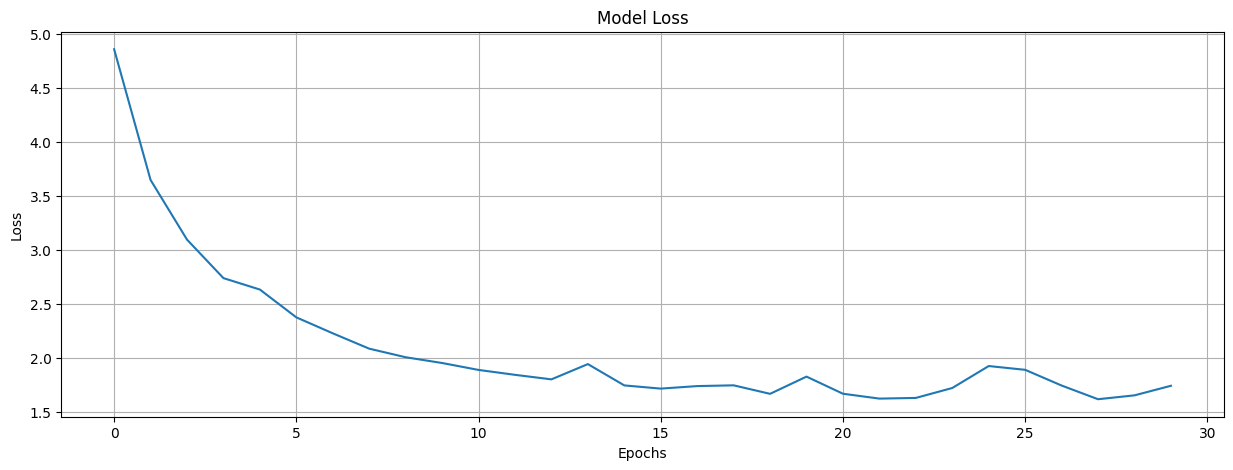

In [23]:
# Fit model
history_simple_RNN = SimpleRNN_model.fit(X, y, epochs = 30, verbose=1)
# save weights
SimpleRNN_model.save_weights('RNN Backup Weights/simple_RNN_model_weights.h5')

plotLossMetrics(history_simple_RNN)

<h4><b>B. Simple LSTM model</b></h4>

Why LSTM?:
- To remember the information for longer periods of time by having an internal memory.
- As mentioned about the exploding gradient, the reason for this is because of the capturing of relevant & irrelevant information.
- LSTM has 3 gates to help control what information is to be kept & what is to be throw out.
    1. Forget Gate:
        - Decides what information is to be carried out forward or what information should be ignored.
        - Information from previous hidden states and the current state information passes through the sigmoid function. 
        - Values that come out from sigmoid are always between 0 and 1. if the value is closer to 1 means information should proceed forward and if value closer to 0 means information should be ignored.
    2. Input Gate:
        - Passes the relevant information and leads to updating cell states, saving updating the wight
        - Adds new relevant information to existing information by updating cell states
    3. Output Gate:
        - Generates next hidden states and cell states are carried over the next time step
- Hence, solving the exploding & vanishing gradeint problem. 
- https://www.analyticsvidhya.com/blog/2017/12/fundamentals-of-deep-learning-introduction-to-lstm/#h-3-improvement-over-rnn-lstm-long-short-term-memory-networks

<img src='https://cdn-images-1.medium.com/max/1500/1*Mw4W7FZUbSr4EoriB5GuqQ.jpeg'>

In [46]:
# Input is max sequence length - 1, as we've removed the last word for the output label
# Input Length is the Sequence length accepted by the Embedding layer
input_len = max_sequence_len - 1 

simple_LSTM_model = Sequential()

# Input Embedding layer
simple_LSTM_model.add(Embedding(total_words, 10, input_length = input_len))

# LSTM layer with 256 units
simple_LSTM_model.add(LSTM(256))

# Control overfitting
simple_LSTM_model.add(Dropout(0.3))

# Output layer
simple_LSTM_model.add(Dense(total_words, activation = 'softmax'))

# simple_LSTM_model summary
simple_LSTM_model.summary()

# Compile simple_LSTM_model
simple_LSTM_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 34, 10)            11990     
                                                                 
 lstm (LSTM)                 (None, 256)               273408    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1199)              308143    
                                                                 
Total params: 593,541
Trainable params: 593,541
Non-trainable params: 0
_________________________________________________________________


Epoch 1/30
1078/1078 [==============================] - 13s 8ms/step - loss: 5.1426
Epoch 2/30
1078/1078 [==============================] - 9s 8ms/step - loss: 4.2912
Epoch 3/30
1078/1078 [==============================] - 9s 8ms/step - loss: 3.6636
Epoch 4/30
1078/1078 [==============================] - 9s 8ms/step - loss: 3.2411
Epoch 5/30
1078/1078 [==============================] - 9s 8ms/step - loss: 2.9414
Epoch 6/30
1078/1078 [==============================] - 8s 8ms/step - loss: 2.7119
Epoch 7/30
1078/1078 [==============================] - 9s 9ms/step - loss: 2.5262
Epoch 8/30
1078/1078 [==============================] - 10s 9ms/step - loss: 2.3798
Epoch 9/30
1078/1078 [==============================] - 9s 9ms/step - loss: 2.2551
Epoch 10/30
1078/1078 [==============================] - 9s 8ms/step - loss: 2.1861
Epoch 11/30
1078/1078 [==============================] - 9s 8ms/step - loss: 2.0579
Epoch 12/30
1078/1078 [==============================] - 9s 8ms/step - loss: 1.9862

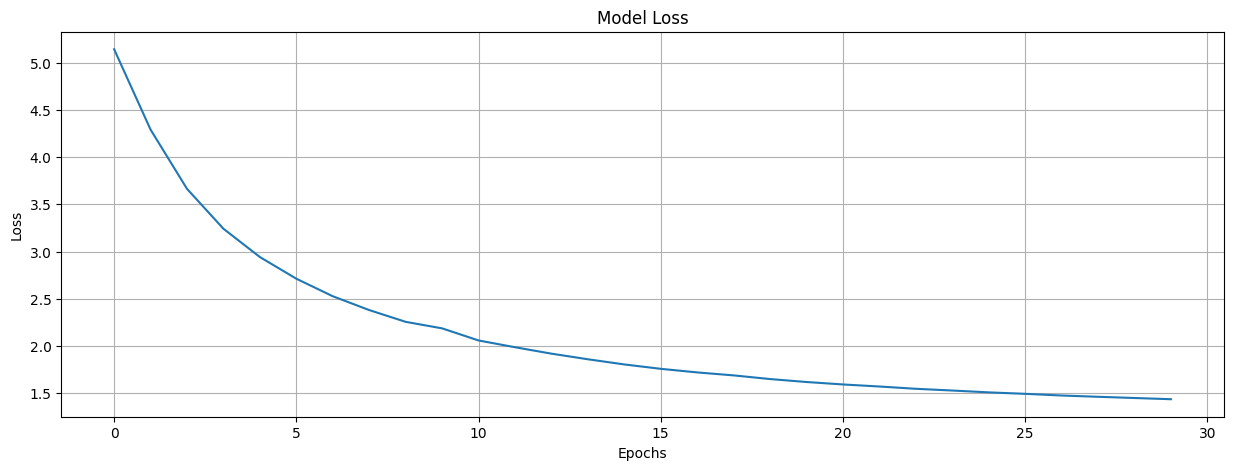

In [25]:
# Fit model
history_simple_LSTM_model = simple_LSTM_model.fit(X, y, epochs = 30, verbose=1)

# save weights
simple_LSTM_model.save_weights('RNN Backup Weights/simple_LSTM_model_weights.h5')

plotLossMetrics(history_simple_LSTM_model)

<h4><b>C. GRU</b></h4>

- Is similar to LSTM networks, as it helps to solve the issue of exploding & vanishing gradient problems.
- However, it does not cotain a cell state, uses its hidden states to transport information and is faster.
- Contains 2 Gates:
    1. Update Gate:
        - Combination of Forget Gate & Input Fate. 
        - Forget gate decides what information to ignore and what information to add in memory
    2. Reset Gate:
        - Past information in order to get rid of graident explosion.
        - Determines how much past information should be forgetten.

<img src='https://cdn-images-1.medium.com/max/1500/1*zFhmhw_SZcX4kUVQH-z2aw.jpeg'>

In [47]:
# Input is max sequence length - 1, as we've removed the last word for the output label
# Input Length is the Sequence length accepted by the Embedding layer
input_len = max_sequence_len - 1 

simple_GRU_model = Sequential()

# Input Embedding layer
simple_GRU_model.add(Embedding(total_words, 10, input_length = input_len))

simple_GRU_model.add(SpatialDropout1D(0.3))

# LSTM layer with 256 units
simple_GRU_model.add(GRU(256))

# Output layer
simple_GRU_model.add(Dense(total_words, activation = 'softmax'))

# simple_GRU_model summary
simple_GRU_model.summary()

# Compile simple_GRU_model
simple_GRU_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 34, 10)            11990     
                                                                 
 spatial_dropout1d (SpatialD  (None, 34, 10)           0         
 ropout1D)                                                       
                                                                 
 gru (GRU)                   (None, 256)               205824    
                                                                 
 dense_2 (Dense)             (None, 1199)              308143    
                                                                 
Total params: 525,957
Trainable params: 525,957
Non-trainable params: 0
_________________________________________________________________


Epoch 1/30
1078/1078 [==============================] - 7s 5ms/step - loss: 4.9454
Epoch 2/30
1078/1078 [==============================] - 6s 5ms/step - loss: 3.8803
Epoch 3/30
1078/1078 [==============================] - 6s 5ms/step - loss: 3.3968
Epoch 4/30
1078/1078 [==============================] - 6s 5ms/step - loss: 3.0788
Epoch 5/30
1078/1078 [==============================] - 5s 5ms/step - loss: 2.8453
Epoch 6/30
1078/1078 [==============================] - 5s 5ms/step - loss: 2.6829
Epoch 7/30
1078/1078 [==============================] - 6s 5ms/step - loss: 2.5384
Epoch 8/30
1078/1078 [==============================] - 6s 6ms/step - loss: 2.4377
Epoch 9/30
1078/1078 [==============================] - 6s 6ms/step - loss: 2.3453
Epoch 10/30
1078/1078 [==============================] - 6s 6ms/step - loss: 2.2643
Epoch 11/30
1078/1078 [==============================] - 5s 5ms/step - loss: 2.2091
Epoch 12/30
1078/1078 [==============================] - 6s 6ms/step - loss: 2.1568
E

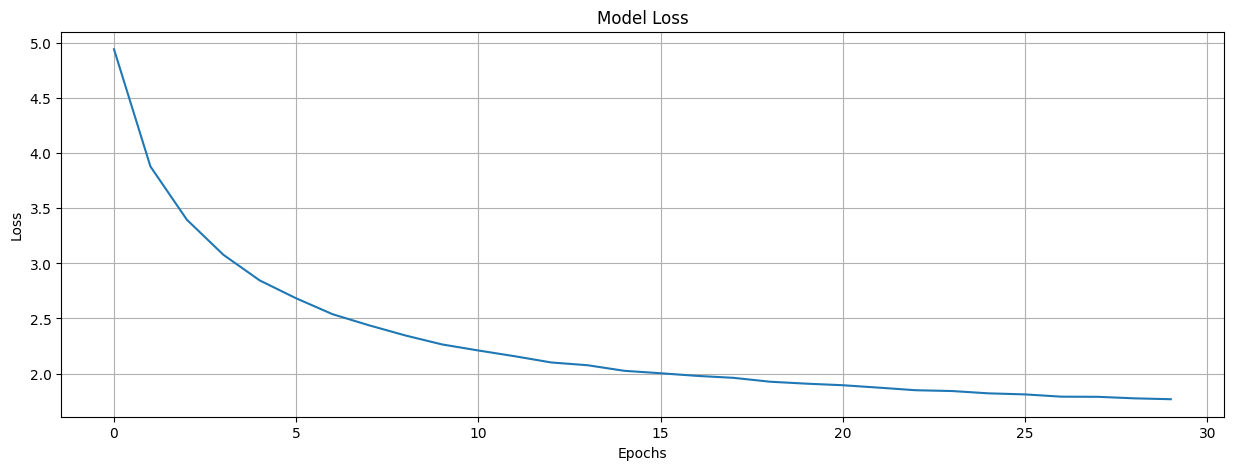

In [30]:
# Fit model
history_simple_GRU_model = simple_GRU_model.fit(X, y, epochs = 30, verbose=1)

# save weights
simple_GRU_model.save_weights('RNN Backup Weights/simple_GRU_model_weights.h5')

plotLossMetrics(history_simple_GRU_model)

<h4><b>D. Bi-directional LSTM</b></h4>

- Advancements of unidirectional LSTM.
- Tries to capture information from both sides left to right and right to left.
- Have the sequence information in both directions backwards (future to past) or forward (past to future)
- Make input flow in both directions to preserve future and past information.
- By having a past sentence and future sentence, we can easily predict the sentence.
- Good for sequence to sequence tasks.

<img src='https://cdn-images-1.medium.com/max/1500/1*seUZsO7Kc19aOPct3G9mmg.jpeg'>

Source:<br>
https://medium.com/@anishnama20/understanding-bidirectional-lstm-for-sequential-data-processing-b83d6283befc#:~:text=The%20Bidirectional%20LSTM%20layer%20processes,function%2C%20optimizer%2C%20and%20metrics.

In [48]:
# Input is max sequence length - 1, as we've removed the last word for the output label
# Input Length is the Sequence length accepted by the Embedding layer
input_len = max_sequence_len - 1 

bidirectional_LSTM_model = Sequential()

# Input Embedding layer (input_dim, output_dim, input_lengtth)
bidirectional_LSTM_model.add(Embedding(total_words, 10, input_length = input_len))

# LSTM layer with 256 units
bidirectional_LSTM_model.add(Bidirectional(LSTM(256)))

# Control overfitting
bidirectional_LSTM_model.add(Dropout(0.3))

# Output layer
bidirectional_LSTM_model.add(Dense(total_words, activation = 'softmax'))

# bidirectional_LSTM_model summary
bidirectional_LSTM_model.summary()

# Compile bidirectional_LSTM_model
bidirectional_LSTM_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 34, 10)            11990     
                                                                 
 bidirectional (Bidirectiona  (None, 512)              546816    
 l)                                                              
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 1199)              615087    
                                                                 
Total params: 1,173,893
Trainable params: 1,173,893
Non-trainable params: 0
_________________________________________________________________


Epoch 1/30
1078/1078 [==============================] - 19s 16ms/step - loss: 5.0931 - accuracy: 0.1170
Epoch 2/30
1078/1078 [==============================] - 14s 13ms/step - loss: 4.2957 - accuracy: 0.1922
Epoch 3/30
1078/1078 [==============================] - 9s 9ms/step - loss: 3.6993 - accuracy: 0.2777
Epoch 4/30
1078/1078 [==============================] - 11s 10ms/step - loss: 3.2570 - accuracy: 0.3344
Epoch 5/30
1078/1078 [==============================] - 10s 10ms/step - loss: 2.9453 - accuracy: 0.3762
Epoch 6/30
1078/1078 [==============================] - 11s 10ms/step - loss: 2.7007 - accuracy: 0.4078
Epoch 7/30
1078/1078 [==============================] - 9s 8ms/step - loss: 2.5179 - accuracy: 0.4320
Epoch 8/30
1078/1078 [==============================] - 9s 9ms/step - loss: 2.3661 - accuracy: 0.4576
Epoch 9/30
1078/1078 [==============================] - 11s 10ms/step - loss: 2.2330 - accuracy: 0.4792
Epoch 10/30
1078/1078 [==============================] - 10s 9ms/step 

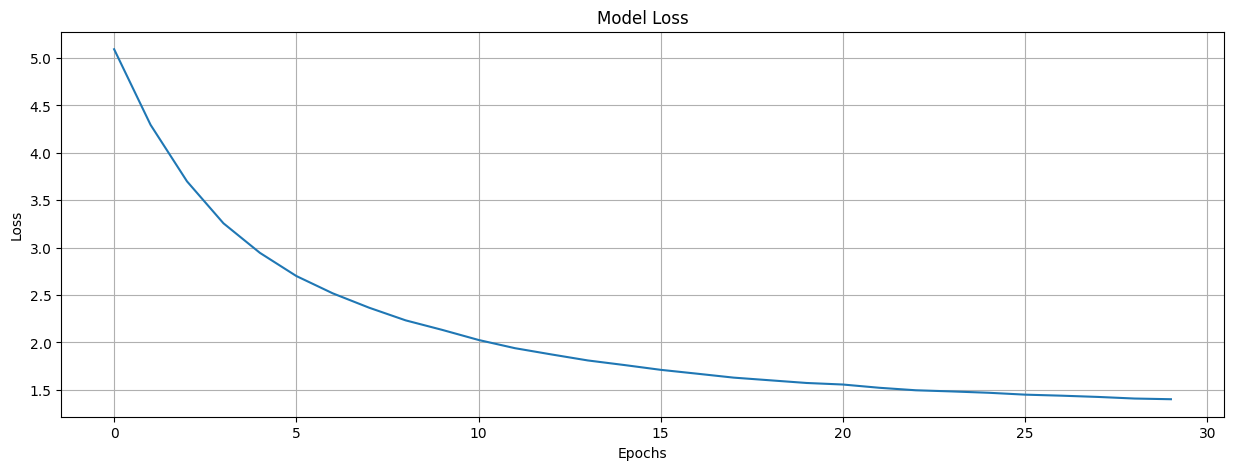

In [34]:
# Fit model
history_bidirectional_LSTM_model = bidirectional_LSTM_model.fit(X, y, epochs = 30, verbose=1)

# save weights
bidirectional_LSTM_model.save_weights('RNN Backup Weights/bidirectional_LSTM_model_weights.h5')

plotLossMetrics(history_bidirectional_LSTM_model)

<hr>
<h2><mark>5. Model Evaluation</mark></h2>

Prediction with <u>Simple RNN Model</u>

In [51]:
SimpleRNN_model.load_weights('RNN Backup Weights/simple_RNN_model_weights.h5')
evaluationAll(SimpleRNN_model)

embrace each day with strength for they are the seeds to your indomitable
radiate some love for they paint singapore's energy of life's journey in
believe that ignites transformation of the spirit of life and strength that
life's actual purpose is a haven of joy a beacon a treasure in yourself
dance through each and every person on which and understanding of your heart for the
let your time and energy of self expression of self expression for it leads your
every person is it with joy in perfect ever expanding wonder to chek
our country Singapore is bitterness is woven and stability of purpose let it lead
planet earth is palpable clarke quay adventure of the moments for it knows
morning and evening would make it can resonate in our planet we plant hope nourishes our


,Generated Text,Perplexity,BLEU Score
0,embrace each day with strength for they are th...,4746.506836,0.692308
1,radiate some love for they paint singapore's e...,87.396080,0.148352
2,believe that ignites transformation of the spi...,16.923763,0.363636
3,life's actual purpose is a haven of joy a beac...,53.238903,0.666667
4,dance through each and every person on which a...,37.290924,0.533333
5,let your time and energy of self expression of...,40.553444,0.495238
6,every person is it with joy in perfect ever ex...,761.440063,0.461538
7,our country Singapore is bitterness is woven a...,50.046631,0.181319
8,planet earth is palpable clarke quay adventure...,620.939148,0.384615
9,morning and evening would make it can resonate...,31.316708,0.150000


Prediction with <u>Simple LSTM Model</u>

In [42]:
simple_LSTM_model.load_weights('RNN Backup Weights/simple_LSTM_model_weights.h5')
evaluationAll(simple_LSTM_model)

embrace each day brings new opportunities and heart in your sails a soul
radiate some authenticity for it turns even to change you encounter in
believe that they are a beacon for be a story worthy a
life's actual purpose is a canvas an potential that protect you of purpose that
dance through each and every beautiful when in perfect beautiful life to our dreams unfold
let your time and energy and happiness intertwine of the heart to the beauty and
every person is the moments in any challenge rugged wonder of life in
our country Singapore is the classroom on the canvas that brings life blessings of
planet earth is a testament of our commitment from our planet offers its
morning and evening would make it be the foundation you of joy and contentment change and


,Generated Text,Perplexity,BLEU Score
0,embrace each day brings new opportunities and ...,19.541046,0.384615
1,radiate some authenticity for it turns even to...,152.582458,0.303030
2,believe that they are a beacon for be a story ...,31.123814,0.333333
3,life's actual purpose is a canvas an potential...,139.884735,0.309524
4,dance through each and every beautiful when in...,39.234272,0.533333
5,let your time and energy and happiness intertw...,29.953531,0.571429
6,every person is the moments in any challenge r...,44.235325,0.333333
7,our country Singapore is the classroom on the ...,965.462891,0.263736
8,planet earth is a testament of our commitment ...,64.445023,0.461538
9,morning and evening would make it be the found...,74.758247,0.466667


Prediction with <u>Simple GRU Model</u>

In [43]:
simple_GRU_model.load_weights('RNN Backup Weights/simple_GRU_model_weights.h5')
evaluationAll(simple_GRU_model)

embrace each day with the tranquility into your soul paint it well from
radiate some strength for they new beginnings to being fully set and
believe that picture of serenity of joy for others to grow ourselves
life's actual purpose is a sanctuary that resonates into the beauty a reminder within
dance through each and every truly exists is our resilience to inspire ourselves uplift anything
let your time and energy are its cities to most beautiful chaos to soul and
every person is the delicate rings go in the hearts of many asia
our country Singapore is explored life moments singapore's time coastal unique when we move
planet earth is built of the find you leave footprints and inspiration of
morning and evening would make it is your beacon in the moments of life you leave


,Generated Text,Perplexity,BLEU Score
0,embrace each day with the tranquility into you...,44.511528,0.384615
1,radiate some strength for they new beginnings ...,213.625046,0.060606
2,believe that picture of serenity of joy for ot...,39.352131,0.272727
3,life's actual purpose is a sanctuary that reso...,778.774353,0.400000
4,dance through each and every truly exists is o...,22.307394,0.171429
5,let your time and energy are its cities to mos...,40.333496,0.185714
6,every person is the delicate rings go in the h...,1119.560791,0.173077
7,our country Singapore is explored life moments...,24.216316,0.185714
8,planet earth is built of the find you leave fo...,170.530136,0.064103
9,morning and evening would make it is your beac...,19.040134,0.350000


Prediction with <u>Bi-directional LSTM Model</u>

In [49]:
# load weights
bidirectional_LSTM_model.load_weights('RNN Backup Weights/bidirectional_LSTM_model_weights.h5')
evaluationAll(bidirectional_LSTM_model)

embrace each day with a gift a soul for new planet and adventures
radiate some love it is its own song it with vibrant hearts
believe that reverberates to life's moment savoring our reserve is the canvas
life's actual purpose is an spreading warmth in your canvas a beacon that you
dance through each and every step we can protect joy waiting to love and forgive
let your time and energy and joy and let go and mysteries will leave in
every person is an when from the seeds a canvas you can light
our country Singapore is an agent to safeguard a path with strength to grow
planet earth is diverse you up your true potential you find peace be
morning and evening would make it is your guiding star up a world from abundance for


,Generated Text,Perplexity,BLEU Score
0,embrace each day with a gift a soul for new pl...,60.162182,0.384615
1,radiate some love it is its own song it with v...,107.141907,0.045455
2,believe that reverberates to life's moment sav...,63.511147,0.352564
3,life's actual purpose is an spreading warmth i...,315.335236,0.533333
4,dance through each and every step we can prote...,177.808853,0.714286
5,let your time and energy and joy and let go an...,80.326118,0.495238
6,every person is an when from the seeds a canva...,132.551453,0.384615
7,our country Singapore is an agent to safeguard...,193.187881,0.241758
8,planet earth is diverse you up your true poten...,85.598717,0.352564
9,morning and evening would make it is your guid...,15.723119,0.350000


After comparing the Perplexity & BLEU Score across the 4 models, in general, Bi-directional LSTM Model appears to be the best peforming one as it has the least perplexity.

Hence, I will select Bi-directional LSTM Model to improve on.

<hr>
<h2><mark>6. Model Improvement</mark></h2>

<h4>1. I will make the model more complex by <u>adding one more Bidirectional LSTM layer</u>.</h4>

In order to increase the model's capcity to learn complex patterns & representations from the input data.

Also to allow the model to capture more extensive contextual information to make more accurate predctions.

In [52]:
# Input is max sequence length - 1, as we've removed the last word for the output label
# Input Length is the Sequence length accepted by the Embedding layer
input_len = max_sequence_len - 1 

bidirectional_LSTM_model_2 = Sequential()

# Input Embedding layer (input_dim, output_dim, input_lengtth)
bidirectional_LSTM_model_2.add(Embedding(total_words, 10, input_length = input_len))

# LSTM layer with 256 units
bidirectional_LSTM_model_2.add(Bidirectional(LSTM(256, return_sequences = True)))

# Control overfitting
bidirectional_LSTM_model_2.add(Dropout(0.3))

# LSTM layer with 256 units
bidirectional_LSTM_model_2.add(Bidirectional(LSTM(256)))

# Control overfitting
bidirectional_LSTM_model_2.add(Dropout(0.3))

# Output layer
bidirectional_LSTM_model_2.add(Dense(total_words, activation = 'softmax'))

# bidirectional_LSTM_model_2 summary
bidirectional_LSTM_model_2.summary()

# Compile bidirectional_LSTM_model_2
bidirectional_LSTM_model_2.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 34, 10)            11990     
                                                                 
 bidirectional_1 (Bidirectio  (None, 34, 512)          546816    
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 34, 512)           0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 512)              1574912   
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 1199)             

Epoch 1/30
1078/1078 [==============================] - 29s 23ms/step - loss: 4.9447 - accuracy: 0.1340
Epoch 2/30
1078/1078 [==============================] - 20s 19ms/step - loss: 4.0664 - accuracy: 0.2166
Epoch 3/30
1078/1078 [==============================] - 24s 23ms/step - loss: 3.5609 - accuracy: 0.2807
Epoch 4/30
1078/1078 [==============================] - 25s 23ms/step - loss: 3.2344 - accuracy: 0.3221
Epoch 5/30
1078/1078 [==============================] - 26s 24ms/step - loss: 3.0137 - accuracy: 0.3473
Epoch 6/30
1078/1078 [==============================] - 27s 25ms/step - loss: 2.8124 - accuracy: 0.3732
Epoch 7/30
1078/1078 [==============================] - 27s 25ms/step - loss: 2.6493 - accuracy: 0.3985
Epoch 8/30
1078/1078 [==============================] - 27s 25ms/step - loss: 2.5213 - accuracy: 0.4137
Epoch 9/30
1078/1078 [==============================] - 27s 25ms/step - loss: 2.4079 - accuracy: 0.4341
Epoch 10/30
1078/1078 [==============================] - 27s 25m

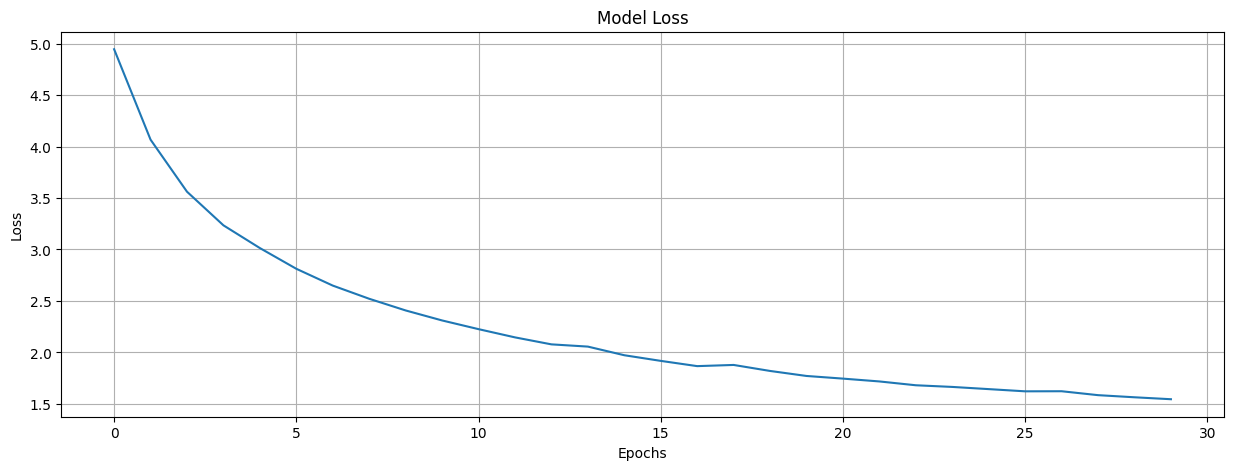

In [130]:
# Fit model
history_bidirectional_LSTM_model_2 = bidirectional_LSTM_model_2.fit(X, y, epochs = 30, verbose=1)

# save weights
bidirectional_LSTM_model_2.save_weights('RNN Backup Weights/bidirectional_LSTM_model_2_weights.h5')

plotLossMetrics(history_bidirectional_LSTM_model_2)

In [56]:
bidirectional_LSTM_model_2.load_weights('RNN Backup Weights/bidirectional_LSTM_model_2_weights.h5')
evaluationAll(bidirectional_LSTM_model_2)

embrace each day with stories for the world moments for others to believe
radiate some peace to overcome for our inner compass into to up
believe that breathe resilience and strength a legacy of care into treasures
life's actual purpose is contagious you is an strength and let your spirit and
dance through each and every shore lies possibilities that carry secrets that than flight of
let your time and energy of kindness for others they hold secrets waiting kindness be
every person is a step we hear of kindness that touch your reality
our country Singapore is painted and vibrant experiences singapore's beauty to persevere and transform
planet earth is the foundation of genuine where resilience and unites defines our
morning and evening would make it for our dreams for our planet offers a testament a


,Generated Text,Perplexity,BLEU Score
0,embrace each day with stories for the world mo...,65.744736,3.525641e-01
1,radiate some peace to overcome for our inner c...,592.254456,1.483383e-308
2,believe that breathe resilience and strength a...,118.587440,3.030303e-01
3,life's actual purpose is contagious you is an ...,51.895081,4.666667e-01
4,dance through each and every shore lies possib...,43.877712,2.857143e-01
5,let your time and energy of kindness for other...,73.958229,6.000000e-01
6,every person is a step we hear of kindness tha...,229.311356,6.153846e-01
7,our country Singapore is painted and vibrant e...,45.545406,4.000000e-01
8,planet earth is the foundation of genuine wher...,16.096470,2.820513e-01
9,morning and evening would make it for our drea...,95.122551,2.916667e-01


Has proven to be beneficial to model performance, as the perplexity and BLEU score are both low.

<h4>2. Next <u>increase the dimensionality of word embeddings</u> from 10 to 32.</h4>

I want to investigate if increasing dimensionality of word embeddings will capture more complex relationships between the words.

By increasing the number of dimensions, the model has a larger capacity to learn richer & more expressive representations.

Also to reduce information loss that might have been suffered from lower-dimensional embeddings.

In [57]:
# Input is max sequence length - 1, as we've removed the last word for the output label
# Input Length is the Sequence length accepted by the Embedding layer
input_len = max_sequence_len - 1 

bidirectional_LSTM_model_3 = Sequential()

# Input Embedding layer (input_dim, output_dim, input_lengtth)
bidirectional_LSTM_model_3.add(Embedding(total_words, 32, input_length = input_len))

# LSTM layer with 256 units
bidirectional_LSTM_model_3.add(Bidirectional(LSTM(256, return_sequences = True)))

# Control overfitting
bidirectional_LSTM_model_3.add(Dropout(0.3))

# LSTM layer with 256 units
bidirectional_LSTM_model_3.add(Bidirectional(LSTM(256)))

# Control overfitting
bidirectional_LSTM_model_3.add(Dropout(0.3))

# Output layer
bidirectional_LSTM_model_3.add(Dense(total_words, activation = 'softmax'))

# bidirectional_LSTM_model_3 summary
bidirectional_LSTM_model_3.summary()

# Compile bidirectional_LSTM_model_3
bidirectional_LSTM_model_3.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 34, 32)            38368     
                                                                 
 bidirectional_3 (Bidirectio  (None, 34, 512)          591872    
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 34, 512)           0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 512)              1574912   
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 1199)             

Epoch 1/30
1078/1078 [==============================] - 26s 21ms/step - loss: 4.8495 - accuracy: 0.1471
Epoch 2/30
1078/1078 [==============================] - 23s 21ms/step - loss: 3.9045 - accuracy: 0.2413
Epoch 3/30
1078/1078 [==============================] - 25s 23ms/step - loss: 3.5100 - accuracy: 0.2914
Epoch 4/30
1078/1078 [==============================] - 26s 24ms/step - loss: 3.2230 - accuracy: 0.3244
Epoch 5/30
1078/1078 [==============================] - 26s 24ms/step - loss: 3.0105 - accuracy: 0.3488
Epoch 6/30
1078/1078 [==============================] - 26s 24ms/step - loss: 2.8473 - accuracy: 0.3725
Epoch 7/30
1078/1078 [==============================] - 25s 23ms/step - loss: 2.6933 - accuracy: 0.3950
Epoch 8/30
1078/1078 [==============================] - 25s 23ms/step - loss: 2.5833 - accuracy: 0.4084
Epoch 9/30
1078/1078 [==============================] - 26s 24ms/step - loss: 2.4851 - accuracy: 0.4231
Epoch 10/30
1078/1078 [==============================] - 25s 23m

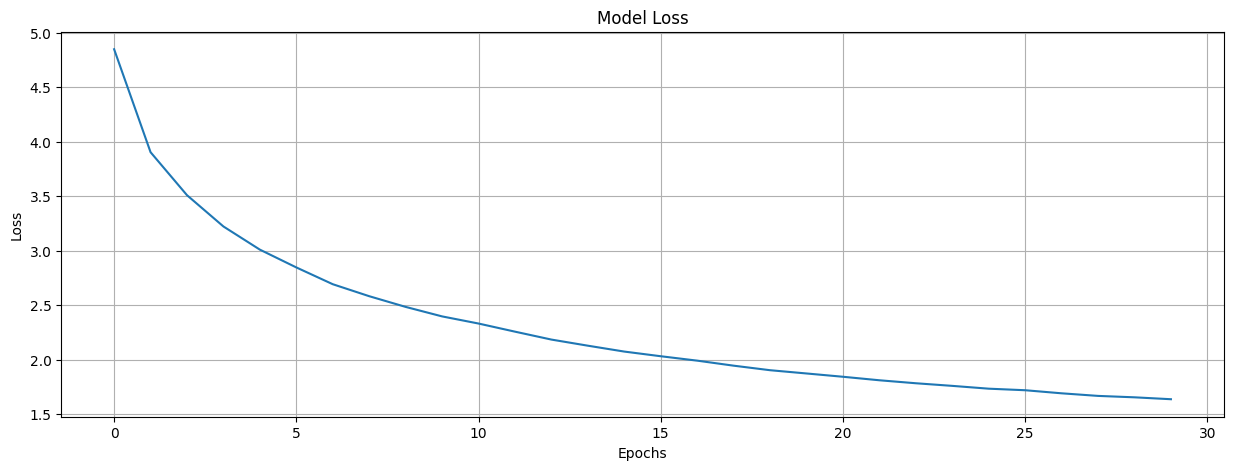

In [132]:
# Fit model
history_bidirectional_LSTM_model_3 = bidirectional_LSTM_model_3.fit(X, y, epochs = 30, verbose=1)

# save weights
bidirectional_LSTM_model_3.save_weights('RNN Backup Weights/bidirectional_LSTM_model_3_weights.h5')

plotLossMetrics(history_bidirectional_LSTM_model_3)

In [58]:
bidirectional_LSTM_model_3.load_weights('RNN Backup Weights/bidirectional_LSTM_model_3_weights.h5')
evaluationAll(bidirectional_LSTM_model_3)

embrace each day is a gift a gift from the heart a serene
radiate some hope it to what be the legacy of resilience in
believe that your lungs for and learning and you will inspire every
life's actual purpose is an open star that resonates with love and kindness be
dance through each and every endeavor is diverse for our planet's ecosystems is a sanctuary
let your time and energy a legacy you home be the light for others have
every person is rich from thrive into treasures for the canvas of true
our country Singapore is diverse of our inner wisdom be of empathy towards the
planet earth is diverse of the world creating waves worthy in the heart
morning and evening would make it is your unique symphony of joy and strength in our


,Generated Text,Perplexity,BLEU Score
0,embrace each day is a gift a gift from the hea...,6.957341,0.352564
1,radiate some hope it to what be the legacy of ...,60.977989,0.083333
2,believe that your lungs for and learning and y...,55.786186,0.250000
3,life's actual purpose is an open star that res...,63.787189,0.433333
4,dance through each and every endeavor is diver...,40.211983,0.625000
5,let your time and energy a legacy you home be ...,110.695534,0.571429
6,every person is rich from thrive into treasure...,113.127335,0.461538
7,our country Singapore is diverse of our inner ...,241.444656,0.395604
8,planet earth is diverse of the world creating ...,186.580444,0.320513
9,morning and evening would make it is your uniq...,22.320000,0.408333


Has proven to be beneficial to model performance, as the perplexity is now below 100, meaning that the model is able to predict the next word better.

Next, I will continue to <u>increase the dimensionality of word embedding to 64</u> to see if it will improve the model performance as well.

In [53]:
# Input is max sequence length - 1, as we've removed the last word for the output label
# Input Length is the Sequence length accepted by the Embedding layer
input_len = max_sequence_len - 1 

bidirectional_LSTM_model_4 = Sequential()

# Input Embedding layer (input_dim, output_dim, input_lengtth)
bidirectional_LSTM_model_4.add(Embedding(total_words, 64, input_length = input_len))

# LSTM layer with 256 units
bidirectional_LSTM_model_4.add(Bidirectional(LSTM(256, return_sequences = True)))

# Control overfitting
bidirectional_LSTM_model_4.add(Dropout(0.3))

# LSTM layer with 256 units
bidirectional_LSTM_model_4.add(Bidirectional(LSTM(256)))

# Control overfitting
bidirectional_LSTM_model_4.add(Dropout(0.3))

# Output layer
bidirectional_LSTM_model_4.add(Dense(total_words, activation = 'softmax'))

# bidirectional_LSTM_model_4 summary
bidirectional_LSTM_model_4.summary()

# Compile bidirectional_LSTM_model_4
bidirectional_LSTM_model_4.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 34, 64)            76736     
                                                                 
 bidirectional_3 (Bidirectio  (None, 34, 512)          657408    
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 34, 512)           0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 512)              1574912   
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 1199)             

Epoch 1/30
1078/1078 [==============================] - 25s 21ms/step - loss: 4.8242 - accuracy: 0.1527
Epoch 2/30
1078/1078 [==============================] - 22s 20ms/step - loss: 3.8013 - accuracy: 0.2688
Epoch 3/30
1078/1078 [==============================] - 23s 21ms/step - loss: 3.3345 - accuracy: 0.3243
Epoch 4/30
1078/1078 [==============================] - 23s 22ms/step - loss: 3.0281 - accuracy: 0.3586
Epoch 5/30
1078/1078 [==============================] - 23s 21ms/step - loss: 2.8141 - accuracy: 0.3844
Epoch 6/30
1078/1078 [==============================] - 23s 21ms/step - loss: 2.6390 - accuracy: 0.4058
Epoch 7/30
1078/1078 [==============================] - 23s 22ms/step - loss: 2.4978 - accuracy: 0.4251
Epoch 8/30
1078/1078 [==============================] - 22s 20ms/step - loss: 2.3721 - accuracy: 0.4431
Epoch 9/30
1078/1078 [==============================] - 20s 19ms/step - loss: 2.2676 - accuracy: 0.4546
Epoch 10/30
1078/1078 [==============================] - 23s 21m

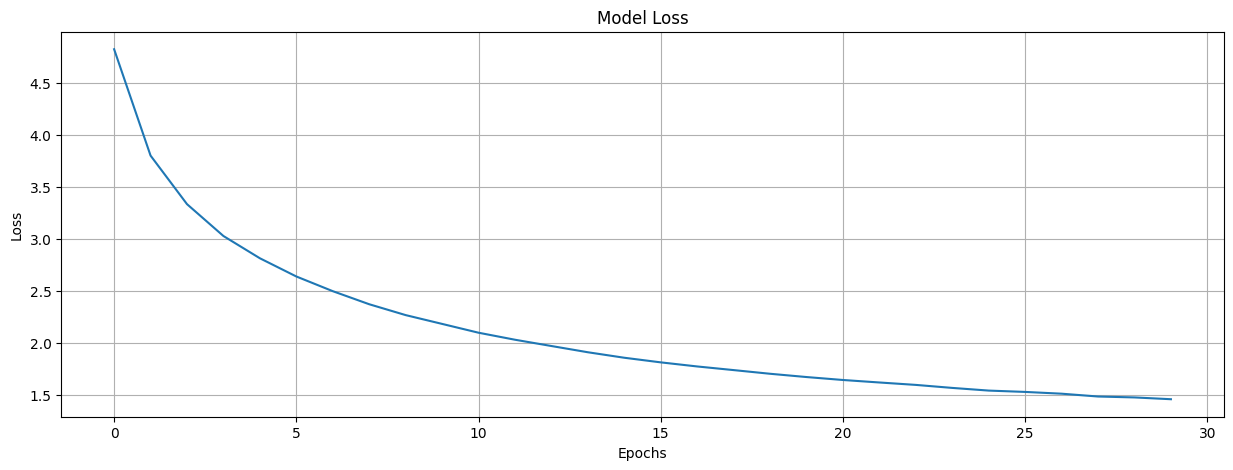

In [78]:
# Fit model
history_bidirectional_LSTM_model_4 = bidirectional_LSTM_model_4.fit(X, y, epochs = 30, verbose=1)

# save weights
bidirectional_LSTM_model_4.save_weights('RNN Backup Weights/bidirectional_LSTM_model_4_weights.h5')

plotLossMetrics(history_bidirectional_LSTM_model_4)

In [55]:
bidirectional_LSTM_model_4.load_weights('RNN Backup Weights/bidirectional_LSTM_model_4_weights.h5')
evaluationAll(bidirectional_LSTM_model_4)

embrace each day carries your way is into the stars it be your
radiate some compassion and determination you through stronger wiser be the armor
believe that propels and uplifts carries diverse and flourish create to change
life's actual purpose is a liberation to the world will are a vibrant tapestry
dance through each and every views are more to purpose resilience and perseverance flourish far
let your time and energy that is the air is your canvas to shine of
every person is a gift that touch our differences for they carry the
our country Singapore is a sanctuary of your soul they hold the keys the
planet earth is an and passion ignites transformation a life in your future
morning and evening would make it is the heartbeat and and vision a sanctuary within your


,Generated Text,Perplexity,BLEU Score
0,embrace each day carries your way is into the ...,192.441803,0.153846
1,radiate some compassion and determination you ...,701.183289,0.121212
2,believe that propels and uplifts carries diver...,952.785950,0.227273
3,life's actual purpose is a liberation to the w...,92.736115,0.400000
4,dance through each and every views are more to...,735.088989,0.285714
5,let your time and energy that is the air is yo...,812.964783,0.500000
6,every person is a gift that touch our differen...,713.681030,0.493590
7,our country Singapore is a sanctuary of your s...,220.793579,0.274725
8,planet earth is an and passion ignites transfo...,334.022888,0.282051
9,morning and evening would make it is the heart...,1941.299561,0.408333


Does not appear to improve the model.

<h4>3. Next <u>add kernel regularizers.</h4>

Help to prevent overfitting & promote more generalizable representations.

<h4><b>A. L1 Regualrization</b></h4>

Adds the absolute values of the coefficients as a penalty term.

Tends to produce sparse weight vectors. This means that it encourages some of the weights to be exactly zero, effectively leading to feature selection.

In [71]:
# Input is max sequence length - 1, as we've removed the last word for the output label
# Input Length is the Sequence length accepted by the Embedding layer
input_len = max_sequence_len - 1 

bidirectional_LSTM_model_4_l1 = Sequential()

# Input Embedding layer (input_dim, output_dim, input_lengtth)
bidirectional_LSTM_model_4_l1.add(Embedding(total_words, 64, input_length = input_len))

# LSTM layer with 256 units
bidirectional_LSTM_model_4_l1.add(Bidirectional(LSTM(256, return_sequences = True, kernel_regularizer=tf.keras.regularizers.l1(0.001))))

# Control overfitting
bidirectional_LSTM_model_4_l1.add(Dropout(0.3))

# LSTM layer with 256 units
bidirectional_LSTM_model_4_l1.add(Bidirectional(LSTM(256, kernel_regularizer=tf.keras.regularizers.l1(0.001))))

# Control overfitting
bidirectional_LSTM_model_4_l1.add(Dropout(0.3))

# Output layer
bidirectional_LSTM_model_4_l1.add(Dense(total_words, activation = 'softmax', kernel_regularizer=tf.keras.regularizers.l1(0.001)))

# bidirectional_LSTM_model_4_l2 summary
bidirectional_LSTM_model_4_l1.summary()

# Compile bidirectional_LSTM_model_4_l2
bidirectional_LSTM_model_4_l1.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 34, 64)            76736     
                                                                 
 bidirectional_7 (Bidirectio  (None, 34, 512)          657408    
 nal)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 34, 512)           0         
                                                                 
 bidirectional_8 (Bidirectio  (None, 512)              1574912   
 nal)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 1199)             

Epoch 1/50
1078/1078 [==============================] - 18s 17ms/step - loss: 6.3009
Epoch 2/50
1078/1078 [==============================] - 13s 12ms/step - loss: 6.1435
Epoch 3/50
1078/1078 [==============================] - 13s 12ms/step - loss: 6.0897
Epoch 4/50
1078/1078 [==============================] - 14s 13ms/step - loss: 6.0587
Epoch 5/50
1078/1078 [==============================] - 15s 14ms/step - loss: 6.0328
Epoch 6/50
1078/1078 [==============================] - 21s 19ms/step - loss: 6.0108
Epoch 7/50
1078/1078 [==============================] - 16s 14ms/step - loss: 5.9918
Epoch 8/50
1078/1078 [==============================] - 14s 13ms/step - loss: 5.9708
Epoch 9/50
1078/1078 [==============================] - 14s 13ms/step - loss: 5.9551
Epoch 10/50
1078/1078 [==============================] - 15s 14ms/step - loss: 5.9355
Epoch 11/50
1078/1078 [==============================] - 16s 14ms/step - loss: 5.9182
Epoch 12/50
1078/1078 [==============================] - 13s 12

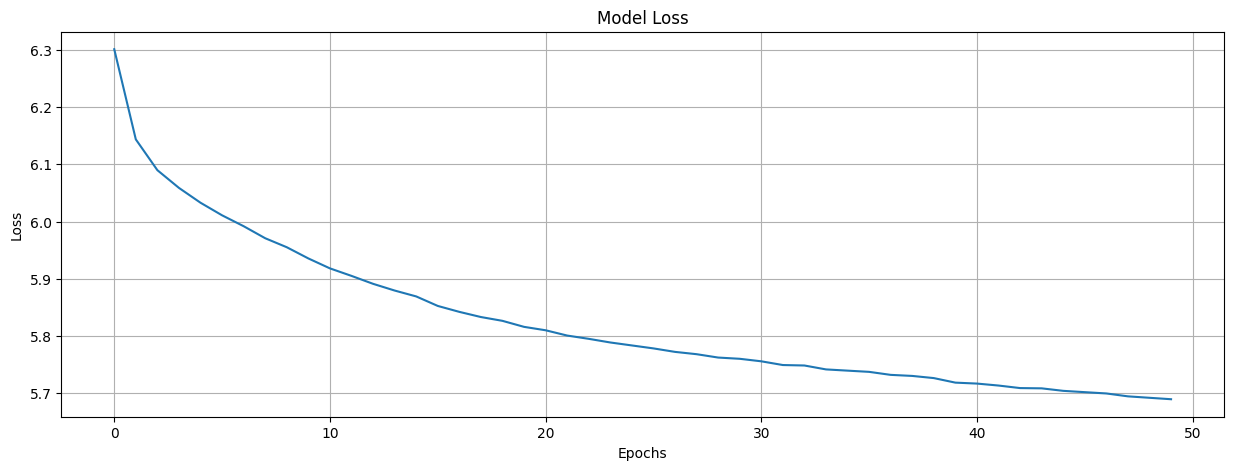

In [90]:
# Fit model
history_bidirectional_LSTM_model_4_l1 = bidirectional_LSTM_model_4_l1.fit(X, y, epochs = 50, verbose=1)

# save weights
bidirectional_LSTM_model_4_l1.save_weights('RNN Backup Weights/bidirectional_LSTM_model_4_l1_weights.h5')

plotLossMetrics(history_bidirectional_LSTM_model_4_l1)

In [76]:
bidirectional_LSTM_model_4_l1.load_weights('RNN Backup Weights/bidirectional_LSTM_model_4_l1_weights.h5')
evaluationAll(bidirectional_LSTM_model_4_l1)

embrace each day your of your a a and your a a of
radiate some of the of your a your of of the a
believe that the of and the a a and your your the
life's actual purpose is the your your and of and a the the a
dance through each and every and your the the your the a a the of
let your time and energy your of and a your of your a of a
every person is your a your your a the the of your the
our country Singapore is your a and and of of of and and and
planet earth is a the a your and and of a your your
morning and evening would make it the the your the of the of and the and


,Generated Text,Perplexity,BLEU Score
0,embrace each day your of your a a and your a a of,28.646908,0.141026
1,radiate some of the of your a your of of the a,19.898693,0.090909
2,believe that the of and the a a and your your the,25.210827,0.181818
3,life's actual purpose is the your your and of ...,25.210827,0.200000
4,dance through each and every and your the the ...,22.605070,0.214286
5,let your time and energy your of and a your of...,26.441669,0.266667
6,every person is your a your your a the the of ...,23.463274,0.230769
7,our country Singapore is your a and and of of ...,29.057339,0.054945
8,planet earth is a the a your and and of a your...,29.114506,0.166667
9,morning and evening would make it the the your...,19.101912,0.108333


Although the perplexity and BLEU score is significantly lower, however based on my human judgement, the generated sentences are not meaningufl and are irrelevant to the context.

<h4><b>B. L2 Regualrizer</b></h4>

Adds the squared values of the coefficients as a penalty term.

L2 regularization penalizes large weights but generally does not force them to become exactly zero. It distributes the penalty across all the weights, leading to a more distributed and "shrinkage" effect. It helps prevent any single weight from becoming too large and dominating the learning process.

In [56]:
# Input is max sequence length - 1, as we've removed the last word for the output label
# Input Length is the Sequence length accepted by the Embedding layer
input_len = max_sequence_len - 1 

bidirectional_LSTM_model_4_l2_2 = Sequential()

# Input Embedding layer (input_dim, output_dim, input_lengtth)
bidirectional_LSTM_model_4_l2_2.add(Embedding(total_words, 64, input_length = input_len))

# LSTM layer with 256 units
bidirectional_LSTM_model_4_l2_2.add(Bidirectional(LSTM(256, return_sequences = True, kernel_regularizer=tf.keras.regularizers.l2(0.001))))

# Control overfitting
bidirectional_LSTM_model_4_l2_2.add(Dropout(0.3))

# LSTM layer with 256 units
bidirectional_LSTM_model_4_l2_2.add(Bidirectional(LSTM(256, kernel_regularizer=tf.keras.regularizers.l2(0.001))))

# Control overfitting
bidirectional_LSTM_model_4_l2_2.add(Dropout(0.3))

# Output layer
bidirectional_LSTM_model_4_l2_2.add(Dense(total_words, activation = 'softmax', kernel_regularizer=tf.keras.regularizers.l2(0.001)))

# bidirectional_LSTM_model_4_l2 summary
bidirectional_LSTM_model_4_l2_2.summary()

# Compile bidirectional_LSTM_model_4_l2
bidirectional_LSTM_model_4_l2_2.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 34, 64)            76736     
                                                                 
 bidirectional_5 (Bidirectio  (None, 34, 512)          657408    
 nal)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 34, 512)           0         
                                                                 
 bidirectional_6 (Bidirectio  (None, 512)              1574912   
 nal)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 1199)             

Epoch 1/50
1078/1078 [==============================] - 16s 13ms/step - loss: 5.6513
Epoch 2/50
1078/1078 [==============================] - 13s 12ms/step - loss: 4.7418
Epoch 3/50
1078/1078 [==============================] - 14s 13ms/step - loss: 4.3984
Epoch 4/50
1078/1078 [==============================] - 13s 13ms/step - loss: 4.2256
Epoch 5/50
1078/1078 [==============================] - 13s 13ms/step - loss: 4.0727
Epoch 6/50
1078/1078 [==============================] - 13s 12ms/step - loss: 4.0007
Epoch 7/50
1078/1078 [==============================] - 13s 12ms/step - loss: 3.9609
Epoch 8/50
1078/1078 [==============================] - 14s 13ms/step - loss: 3.9448
Epoch 9/50
1078/1078 [==============================] - 13s 12ms/step - loss: 3.8815
Epoch 10/50
1078/1078 [==============================] - 13s 12ms/step - loss: 3.8814
Epoch 11/50
1078/1078 [==============================] - 14s 13ms/step - loss: 3.8085
Epoch 12/50
1078/1078 [==============================] - 14s 13

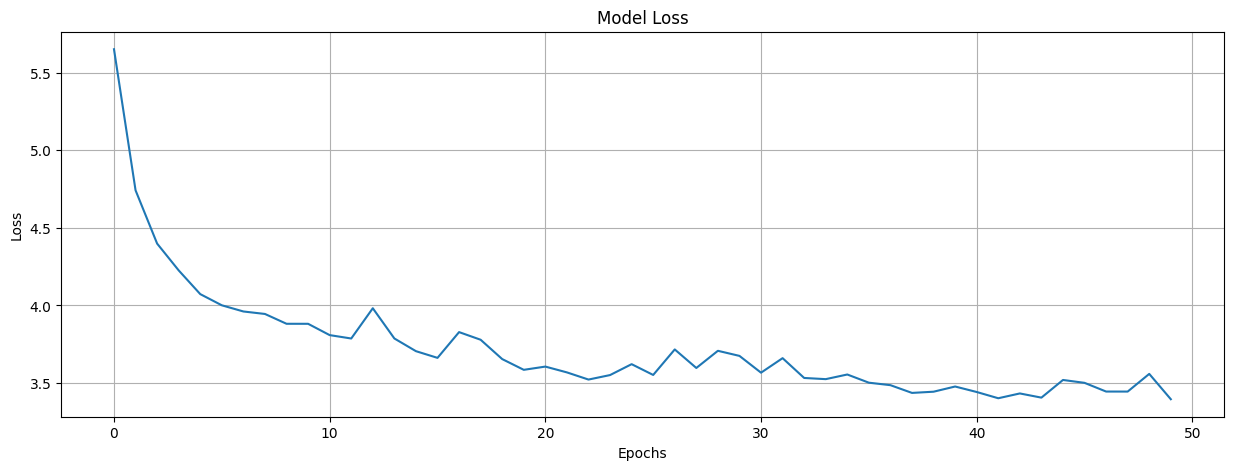

In [84]:
# Fit mo
history_bidirectional_LSTM_model_4_l2_2 = bidirectional_LSTM_model_4_l2_2.fit(X, y, epochs = 50, verbose=1)

# save weights
bidirectional_LSTM_model_4_l2_2.save_weights('RNN Backup Weights/bidirectional_LSTM_model_4_l2_2_weights.h5')

plotLossMetrics(history_bidirectional_LSTM_model_4_l2_2)

In [ ]:
# save weights
bidirectional_LSTM_model_4_l2_2.save_weights('bidirectional_LSTM_model_4_l2_2_best_weights.h5')

In [74]:
bidirectional_LSTM_model_4_l2_2.load_weights('bidirectional_LSTM_model_4_l2_2_best_weights.h5')
evaluationAll(bidirectional_LSTM_model_4_l2_2)

embrace each day let our planet offers of our planet's future is contagious
radiate some kindness it with the compass for your dreams and determination
believe that connects spirit free how the power and compassion and let
life's actual purpose is painted every day let it lead the compass that brightens
dance through each and every step we hear your actions be the power of the
let your time and energy to face that ignites how your actions be the world
every person is a testament for they carry the beauty within every step
our country Singapore is an open that brightens someone's hearts to face that brightens
planet earth is a step a testament of a testament to your dreams
morning and evening would make it with your actions be the power a fresh future for


,Generated Text,Perplexity,BLEU Score
0,embrace each day let our planet offers of our ...,35.651089,0.181319
1,radiate some kindness it with the compass for ...,45.934101,0.151515
2,believe that connects spirit free how the powe...,51.054207,0.303030
3,life's actual purpose is painted every day let...,78.611084,0.433333
4,dance through each and every step we hear your...,13.543922,0.666667
5,let your time and energy to face that ignites ...,19.819592,0.466667
6,every person is a testament for they carry the...,45.942078,0.423077
7,our country Singapore is an open that brighten...,25.694973,0.104762
8,planet earth is a step a testament of a testam...,29.193760,0.750000
9,morning and evening would make it with your ac...,21.654106,0.350000


Has proven to improve the model as the perplexity is now significantly lower and only 2 digits.

<hr>
<h3><b>Final Model: Bi-directional LSTM Model</b></h3>

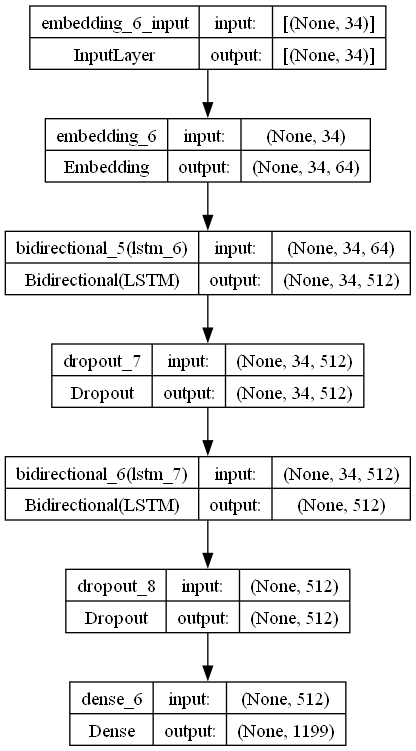

In [57]:
tf.keras.utils.plot_model(bidirectional_LSTM_model_4_l2_2, show_shapes=True)

Producing Different sequences of output texts, given the same input text

In [60]:
bidirectional_LSTM_model_4_l2_2.load_weights('bidirectional_LSTM_model_4_l2_2_best_weights.h5')
print('Iteration 1')
evaluationAll(bidirectional_LSTM_model_4_l2_2)

Iteration 1


embrace each day with each act that brightens your soul and determination and
radiate some kindness it is a reminder that this be stronger vibrant
believe that ignites your dreams be a reminder of a beacon of
life's actual purpose is painted has any obstacle and love for the beauty that
dance through each and every day leaving and watch from your soul and let the
let your time and energy and determination and determination embrace our planet's when towards your
every person is painted has of a beacon for your journey and watch
our country Singapore is an open to shape our hearts and you are opportunities
planet earth is painted has any obstacle and let the power that ignites
morning and evening would make it be your dreams and determination embrace of our experiences with


,Generated Text,Perplexity,BLEU Score
0,embrace each day with each act that brightens ...,38.185783,0.346154
1,radiate some kindness it is a reminder that th...,95.495903,0.106061
2,believe that ignites your dreams be a reminder...,17.732159,0.909091
3,life's actual purpose is painted has any obsta...,90.003899,0.433333
4,dance through each and every day leaving and w...,24.108458,0.571429
5,let your time and energy and determination and...,30.365635,0.375000
6,every person is painted has of a beacon for yo...,72.909897,0.538462
7,our country Singapore is an open to shape our ...,34.223133,0.241758
8,planet earth is painted has any obstacle and l...,93.901680,0.282051
9,morning and evening would make it be your drea...,48.285789,0.466667


In [61]:
print('Iteration 2')
evaluationAll(bidirectional_LSTM_model_4_l2_2)

Iteration 2
embrace each day let the beauty within you are capable a step a
radiate some hope is contagious for your dreams and let gratitude be
believe that connects journey and determination creates a beacon for they paint
life's actual purpose is a testament to the power and compassion that brightens threads
dance through each and every act is painted be a fresh strength be a step
let your time and energy for our hearts up it can heal be of this
every person is the compass for it turns the symphony the compass a
our country Singapore is a reminder the power of positive miracles are a reminder
planet earth is an open that heals and compassion for they carry any
morning and evening would make it is contagious a fresh wisdom to the compass of our


,Generated Text,Perplexity,BLEU Score
0,embrace each day let the beauty within you are...,57.873962,0.141026
1,radiate some hope is contagious for your dream...,49.898636,0.250000
2,believe that connects journey and determinatio...,25.128035,0.227273
3,life's actual purpose is a testament to the po...,26.894287,0.433333
4,dance through each and every act is painted be...,93.614380,0.466667
5,let your time and energy for our hearts up it ...,86.371635,0.357143
6,every person is the compass for it turns the s...,90.092087,0.461538
7,our country Singapore is a reminder the power ...,27.957943,0.274725
8,planet earth is an open that heals and compass...,25.703909,0.173077
9,morning and evening would make it is contagiou...,97.000191,0.408333


In [62]:
print('Iteration 3')
evaluationAll(bidirectional_LSTM_model_4_l2_2)

Iteration 3
embrace each day brings the power of your actions reflect the power within
radiate some kindness it can simplicity are a testament and love and
believe that morning find the world of the beauty that ignites the
life's actual purpose is a testament to our experiences with threads is a beacon
dance through each and every opportunity and watch you are capable a step towards our
let your time and energy a beacon that ignites change for they are the world
every person is a fresh start be your actions lead you leave behind
our country Singapore is a reminder that this be an investment and you will
planet earth is painted with love be the symphony that this morning find
morning and evening would make it can light to shape a reminder to the world around


,Generated Text,Perplexity,BLEU Score
0,embrace each day brings the power of your acti...,30.469507,3.846154e-01
1,radiate some kindness it can simplicity are a ...,38.736183,1.112537e-308
2,believe that morning find the world of the bea...,18.284397,6.363636e-01
3,life's actual purpose is a testament to our ex...,57.235474,5.333333e-01
4,dance through each and every opportunity and w...,62.433571,6.428571e-01
5,let your time and energy a beacon that ignites...,16.500912,6.428571e-01
6,every person is a fresh start be your actions ...,99.378555,3.846154e-01
7,our country Singapore is a reminder that this ...,59.891857,2.417582e-01
8,planet earth is painted with love be the symph...,33.189629,3.333333e-01
9,morning and evening would make it can light to...,64.914505,4.666667e-01


Overall, the model is able to predict creative and meaningful outputs.